<h1 style="font-family: 'Arial'; font-weight: bold; border-bottom: 3px solid #000; padding: 8px; margin-bottom: 20px; text-align: left; letter-spacing: 1px;">House Prices Prediction: XGBoost </h1>

In [52]:
# Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(15,9)})

# Models
from xgboost import XGBRegressor


In [41]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

In [29]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h1 style="font-family: 'Arial'; font-weight: bold; border-bottom: 3px solid #000; padding: 8px; margin-bottom: 20px; text-align: left; letter-spacing: 1px;">Data Preprocessing </h1>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
The training dataset provided contains 1460 rows and 81 columns. <br>
Among the 81 columns, 'SalePrice' is the target variable.
</p>

In [30]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [31]:
df_train.shape

(1460, 81)

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
The following columns have missing values in more than half the total number of rows in the dataset.
<br>
As shown above, the column 'Alley' only have 90 non-null values.
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
This just gave me a fun idea to test out a 'What if' scenario, to see what if I removed the following columns, will it improve the model performance? 
<br>
Of course, I will only do this after I have checked the feature importance.
</p>

In [33]:
columns_with_na = df_train.columns[df_train.isna().sum() > 740].tolist()
print(columns_with_na)

['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


In [34]:
df_train.duplicated().sum()

0

<h1 style="font-family: 'Arial'; font-weight: bold; border-bottom: 3px solid #000; padding: 8px; margin-bottom: 20px; text-align: left; letter-spacing: 1px;">Exploratory Data Analysis (EDA)</h1>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
I have a habit checking the correlation between features to identify any potential high correlations between features and the target variable. This allows me to watch out for situations where a small subset of features might exert a significant influence on the overall prediction outcome.
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
Another benefit of checking the correlation is that it helps us understand the feature better. From the correlation matrix, we can observe the features that are highly correlated with the target feature. 
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
<strong>Positively Correlated:</strong>
<ul style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333;">
    <li>OverallQual: 0.79</li>
    <li>GrLivArea: 0.71</li>
    <li>GarageCars: 0.64</li>
</ul>
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
<strong>Negatively Correlated:</strong>
<ul style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333;">
    <li>ExterQual: -0.64</li>
    <li>BsmtQual: -0.62</li>
    <li>KitchenQual: -0.59</li>
</ul>
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
<strong>Snippets from data dictionary:</strong>
<ul style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333;">
    <li>OverallQual: Rates the overall material and finish of the house</li>
    <li>GrLivArea: Above grade (ground) living area square feet</li>
    <li>GarageCars: Size of garage in car capacity</li>
    <li>ExterQual: Evaluates the quality of the material on the exterior</li>
    <li>BsmtQual: Evaluates the height of the basement</li>
    <li>KitchenQual: Kitchen quality</li>
</ul>
</p>

In [46]:
# Make a copy of the dataframe
df_train_copy = df_train.copy()
# Convert categorical variables to numerical using label encoding
categorical_cols = df_train_copy.select_dtypes(include=['object']).columns

# Apply
for col in categorical_cols:
    le = LabelEncoder()
    df_train_copy[col] = le.fit_transform(df_train[col])

correlation_matrix = df_train_copy.corr()
# Get the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['SalePrice'].drop('SalePrice').sort_values()
print(correlation_with_target)

ExterQual      -0.636884
BsmtQual       -0.620886
KitchenQual    -0.589189
GarageFinish   -0.549247
FireplaceQu    -0.459605
                  ...   
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
Name: SalePrice, Length: 80, dtype: float64


<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
<strong>Statistical Moments</strong>
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
<strong>Moments:</strong>
<ul style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333;">
    <li>First Moment: Mean </li>
    <li>Second Moment: Variance </li>
    <li>Third Moment: Skewness </li>
    <li>Fourth Moment: Kurtosis </li>
</ul>
</p>

<p style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333; text-align: justify;">
<strong>Findings:</strong>
<ul style="font-family: Georgia, 'Arial', serif; font-size: 18px; color: #333;">
    <li><b>Skewness:</b> Our target variable 'SalePrice' is positively skewed. This indicates that the distribution is skewed to the right, meaning the tail of the distribution extends more towards higher values. Suggesting that there may be a concentration of lower values with a few higher values. This is consistent with the observation seen in the distribution chart. </li>
    <li><b>Kurtosis:</b> A Kurtosis of 6.5. This suggest a leptokurtic distribution where the kurtosis is larger than that of a normal distribution, meaning the distribution has heavier tails and a sharper peak compared to a normal distribution</li>
</ul>
</p>

In [50]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [55]:
skewness = skew(df_train['SalePrice'])
kurt = kurtosis(df_train['SalePrice'])

print("Skewness:", skewness)
print("Kurtosis:", kurt)

Skewness: 1.880940746034036
Kurtosis: 6.509812011089439


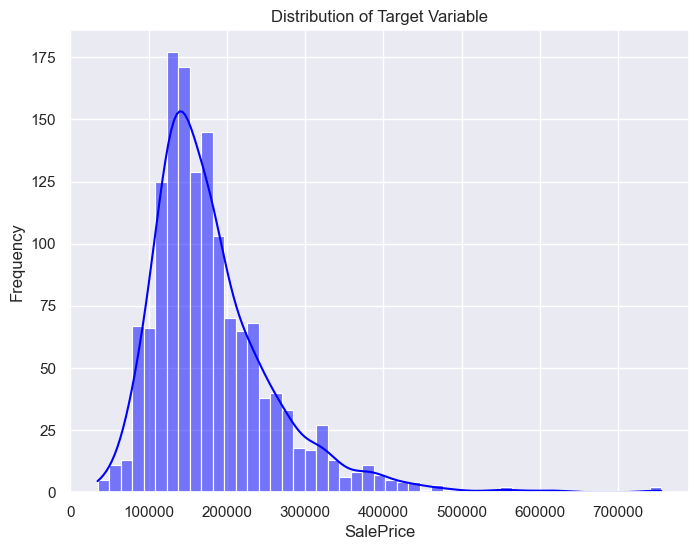

In [56]:
# Distribution of SalePrice
plt.figure(figsize=(8, 6))
sns.histplot(df_train['SalePrice'], kde=True, color='blue')
plt.title('Distribution of Target Variable')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()